In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 19s 599ms/step - loss: 21.4949 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 2s 66ms/step - loss: 21.2292 - mae: 21.6568
Epoch 3/100
31/31 [==============================] - 2s 67ms/step - loss: 20.7762 - mae: 21.2935
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 20.3132 - mae: 20.806 - 2s 65ms/step - loss: 20.3174 - mae: 20.9387
Epoch 5/100
31/31 [==============================] - 2s 72ms/step - loss: 20.1021 - mae: 20.5971
Epoch 6/100
31/31 [==============================] - 2s 74ms/step - loss: 19.8400 - mae: 20.2592
Epoch 7/100
31/31 [==============================] - 2s 67ms/step - loss: 19.4139 - mae: 19.8905
Epoch 8/100
31/31 [==============================] - 2s 49ms/step - loss: 18.8902 - mae: 19.4684
Epoch 9/100
31/31 [==============================] - 2s 49ms/step - loss: 18.5148 - mae: 18.9311
Epoch 10/100
31/31 [==============================] - 2s 50ms/step - loss: 17.8562 - 

31/31 [==============================] - 2s 59ms/step - loss: 13.6781 - mae: 14.1786
Epoch 84/100
31/31 [==============================] - 2s 51ms/step - loss: 13.6235 - mae: 14.1564
Epoch 85/100
31/31 [==============================] - 2s 52ms/step - loss: 13.6222 - mae: 14.1374
Epoch 86/100
31/31 [==============================] - 2s 53ms/step - loss: 13.6440 - mae: 14.1177
Epoch 87/100
31/31 [==============================] - 2s 66ms/step - loss: 13.6920 - mae: 14.0967: 1s - loss: 1
Epoch 88/100
31/31 [==============================] - 2s 64ms/step - loss: 13.5996 - mae: 14.0788: 1s - loss: 13.5005 - ma
Epoch 89/100
31/31 [==============================] - 2s 64ms/step - loss: 13.5709 - mae: 14.0577
Epoch 90/100
31/31 [==============================] - 2s 63ms/step - loss: 13.5366 - mae: 14.0409: 0s - loss: 13.5283 - mae: 14.
Epoch 91/100
31/31 [==============================] - 2s 49ms/step - loss: 13.5037 - mae: 14.0187
Epoch 92/100
31/31 [==============================] - 1s 48ms

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

KeyError: 'lr'

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

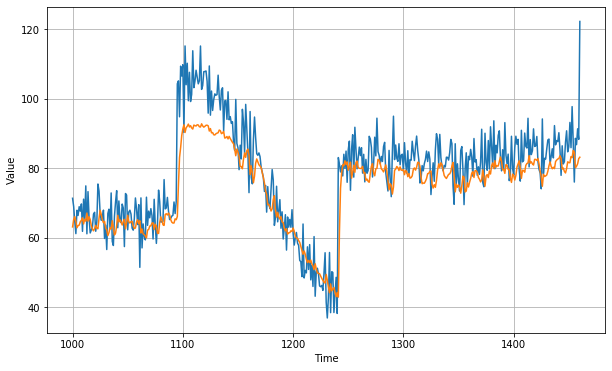

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.1428976

<Figure size 432x288 with 0 Axes>

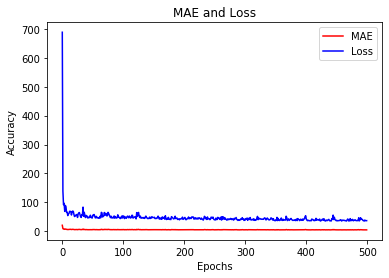

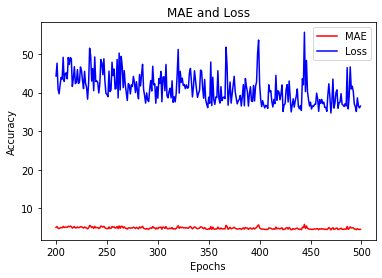

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [10]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [11]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 34s 1s/step - loss: 637.0233
Epoch 2/100
31/31 [==============================] - 3s 86ms/step - loss: 122.3825
Epoch 3/100
31/31 [==============================] - 3s 96ms/step - loss: 93.5221
Epoch 4/100
31/31 [==============================] - 3s 82ms/step - loss: 89.9539
Epoch 5/100
31/31 [==============================] - 3s 87ms/step - loss: 83.9738
Epoch 6/100
31/31 [==============================] - 3s 101ms/step - loss: 75.3470
Epoch 7/100
31/31 [==============================] - 3s 89ms/step - loss: 68.6464 0s - los - ETA: 0s - loss: 68.65
Epoch 8/100
31/31 [==============================] - 3s 112ms/step - loss: 64.6512
Epoch 9/100
31/31 [==============================] - 3s 93ms/step - loss: 66.7151
Epoch 10/100
31/31 [==============================] - 3s 89ms/step - loss: 65.4137
Epoch 11/100
31/31 [==============================] - 3s 85ms/step - loss: 63.6606
Epoch 12/100
31/31 [==============================] - 3s 83m

31/31 [==============================] - 2s 70ms/step - loss: 44.1665
Epoch 99/100
31/31 [==============================] - 2s 71ms/step - loss: 44.7782
Epoch 100/100
31/31 [==============================] - 2s 64ms/step - loss: 45.3298
